In [1]:
# %%
"""Analyze preference button text."""

from pathlib import Path
from collections import Counter

from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from consent.util.default_path import get_data_dir
from consent.data.cookie_setting import CookieSetting
from consent.cmp.prefbtn.pref_btn_clf import PrefBtnClf, predict_dataset
from consent.cmp.prefbtn.pref_btn_featurizer import featurize_attr_df, num_tokens
from ooutil.file import file_empty
from ooutil.nlp_util import get_spaced_lemma

tqdm.pandas()

# pref_btn_dir = get_data_dir("2021-03-01") / 'pref_btn_v7'
# pref_btn_dir = get_data_dir("2021-08-03") / 'pref_btn'
# pref_btn_dir = get_data_dir("2021-08-04") / 'pref_btn'
# pref_btn_dirs = [get_data_dir("2021-08-04") / 'pref_btn', get_data_dir("2021-11-26") / 'pref_btn']
pref_btn_dirs = [get_data_dir("2022-05-24") / 'pref_btn', get_data_dir("2022-05-26") / 'pref_btn']
assert all(pref_btn_dir.exists() for pref_btn_dir in pref_btn_dirs)
# assert pref_btn_dir.exists()
fig_dir = Path.home() / 'local_projects/consent/paper/sp22/figures/'
assert fig_dir.exists()

splits = ['train', 'test']

In [2]:
pref_data = []
for pref_btn_dir in pref_btn_dirs:
    for afile in pref_btn_dir.glob('*.csv'):
        if file_empty(afile):
            print(f'{afile} is empty')
            continue
        pref_data.append(pd.read_csv(afile, index_col=0))

pref_df = pd.concat(pref_data, axis=0, ignore_index=True)
pref_df = pref_df.dropna(subset={'tag_name'})
pref_df = pref_df.fillna('')
print("Number of sites:", pref_df.site.nunique())
print(f"Number of samples: {len(pref_df):,d}")
print("Number of pref buttons", len(pref_df[pref_df.pref_btn]))
pref_df.head()

Number of sites: 298
Number of samples: 71,020
Number of pref buttons 436


,id,class,tag_name,text_content,inner_text,aria_label,title,href,onclick,pref_btn,site
0,,primary-menu-level-2,A,Framed stamps and prints,Framed stamps and prints,,,https://shop.royalmail.com/collectibles-and-gi...,,False,royalmail.com
1,,primary-menu-level-2,A,Find your delivery office,Find your delivery office,,,/services-near-you,,False,royalmail.com
2,,,A,Collect a missed delivery,Collect a missed delivery,,,https://personal.help.royalmail.com/app/answer...,,False,royalmail.com
3,,primary-menu-level-2,A,Return an item,Return an item,,,/track-my-return/pick-a-retailer,,False,royalmail.com
4,,,SPAN,Get in touch,Get in touch,,,,,False,royalmail.com


In [3]:
# pref_df['consent_lib'] = pref_df.site.map(lambda site: CookieSetting.get_consent_lib(site))
for col in ['id', 'class']:
    pref_df[col] = pref_df[col].astype(str)

# def analyze_sites():
sites = pref_df.site.unique()

for site in sites:
    if len(pref_df[(pref_df.site == site) & (pref_df.pref_btn)]) == 0:
        print(f'no pref btn for {site}')
        break
pref_df[ (pref_df.inner_text.str.len() > 40) & (pref_df.pref_btn) ]
print("Number of sites in pref_df:", pref_df.site.nunique())

Number of sites in pref_df: 298


In [4]:
# Featurizing.
cols = ['site', 'id', 'class', 'inner_text', 'aria_label', 'title', 'pref_btn', 'onclick', 'href'] # , 'consent_lib']
pr_df = pref_df[cols]
# pr_df = pr_df[pr_df.consent_lib != 'first_party']
print("Number of sites in pr_df:", pr_df.site.nunique())

feat, feat_group_dims = featurize_attr_df(pr_df.copy())
print("Feature group dimensions:", feat_group_dims)

acc_group_dims = []
group_dim = 0
for dim in feat_group_dims:
    group_dim += dim
    acc_group_dims.append(group_dim)
acc_group_dims

Number of sites in pr_df: 298
Feature group dimensions: [12, 3, 2]


[12, 15, 17]

In [5]:
# ML models, train and predict.

def kfold_eval(pr_df, feat_df, tops=(1,3,5,7,10), aclf=None, verbose=0):
    np.random.seed(1025)
    sites = pr_df.site.unique() # .tolist()
    np.random.shuffle(sites)

    kf = KFold(n_splits=10) # , shuffle=True, random_state=1025)
    results = []
    i = 0
    for train_idxes, test_idxes in kf.split(sites):
        train_sites = sites[train_idxes]
        test_sites = sites[test_idxes]
        assert len(set(train_sites).intersection(set(test_sites))) == 0, 'train and test sites overlap'

        train_mask, test_mask = pr_df.site.isin(train_sites), pr_df.site.isin(test_sites)
        train, test = pr_df[train_mask].copy(), pr_df[test_mask].copy()
        train_feat, test_feat = feat_df[train_mask], feat_df[test_mask]

        fold_result = eval_train_test(train, test, train_feat, test_feat, tops, aclf)
        results.append(fold_result)
        if verbose >= 2: print(fold_result)

    return pd.concat(results)

def eval_train_test(train, test, train_feat, test_feat, tops, aclf, verbose=0):
    # Featurize train and test.
    # train_feat, feat_group_dims = featurize_attr_df(train)
    # test_feat, _ = featurize_attr_df(test)

    # train_feat.toarray()[:3]
    if verbose >= 2:
        print('Number of feature dimensions:', train_feat.shape[1])
        print('Shape of train feat:', train_feat.shape)
    return run_predict_dataset(train, test, train_feat, test_feat, tops, aclf)


def run_predict_dataset(train, test, train_feat, test_feat, tops, aclf):
    dataset_splits = {'train': train, 'test': test}
    dataset_feats = {'train': train_feat, 'test': test_feat}

    clf = PrefBtnClf.train_and_save(train_feat, train['pref_btn'].to_list(), aclf=aclf)

    for split in splits:
        predict_dataset(clf, dataset_splits[split], dataset_feats[split])

    return get_eval_results(clf, dataset_splits, tops)

def get_eval_results(clf, dataset_splits, tops):
    eval_data = []
    for split in splits:
        eval_on_site(split, dataset_splits[split], eval_data, tops)
    return pd.DataFrame(eval_data)

def eval_on_site(data_name, adf, eval_data, tops, verbose=0):
    if verbose >= 2: print(f"[{data_name}] Num sites:", adf['site'].nunique())
    for top_n in tops: # [1,3,5,7,10]:
        # print(f'{top_n=}')
        accuracy = get_accuracy_top_n(adf, top_n)
        eval_data.append({
            'split': data_name,
            'top_n': top_n,
            'accuracy': accuracy,
        })

def get_accuracy_top_n(adf, top_n):
    n_correct = 0
    sites = set(adf['site'].tolist())
    for site in sites:
        if pred_one_correct(adf[adf.site == site], top_n): # , top_n=top_n):
            n_correct += 1
    return n_correct / len(sites)

def pred_one_correct(adf: pd.DataFrame, top_n, verbose=0):
    # adf = adf[adf['proba'] >= 0.5]  # cut off anything below 0.5
    adf = adf.sort_values(by=['proba'], ascending=False)[:top_n]
    correct_positives = adf[adf['pref_btn']]
    if verbose >= 2: print(correct_positives)
    return len(correct_positives) > 0
    # return len(adf[adf['pref_btn'] == adf['pred']]) > 0

class TestPrefBtnClf:
    """This class uses PrefBtnClf to get the metrics for testing.
    It mirros get_eval_result(). The computation is very slow because it computes per site."""
    # Get the top-k prediction accuracy scores.
    @classmethod
    def pred_one_correct(cls, adf: pd.DataFrame, verbose=0): # , top_n):
    #     adf = adf.sort_values(by=['proba'], ascending=False)[:top_n]
        # return len(adf[adf['pref_btn'] == adf['pred']]) > 0
        correct_positives = adf[adf['pref_btn']]
        if verbose >= 2: print(correct_positives)
        return len(correct_positives) > 0

    @classmethod
    def get_accuracy_top_n(cls, clf, adf, feat_df, top_n):
        n_correct = 0
        sites = set(adf['site'].tolist())
        for site in sites:
            site_mask = adf.site == site
            top_n_df = PrefBtnClf.get_top_n(adf[site_mask].copy(), feat_df[site_mask].copy(), top_n=top_n, clf=clf)
            # if pred_one_correct(adf[adf.site == site], top_n=top_n):
            if cls.pred_one_correct(top_n_df): # , top_n=top_n):
                n_correct += 1
        return n_correct / len(sites)

    @classmethod
    def eval_on_site(cls, clf, data_name, adf, feat_df, eval_data):
        print(f"[{data_name}] Num sites:", adf['site'].nunique())
        for top_n in [1,2,3]:
            # print(f'{top_n=}')
            accuracy = cls.get_accuracy_top_n(clf, adf, feat_df, top_n)
            eval_data.append({
                'split': data_name,
                'top_n': top_n,
                'accuracy': accuracy,
            })

    @classmethod
    def get_eval_results(cls, clf, dataset_splits, dataset_feats):
        eval_data = []
        for split in splits:
            cls.eval_on_site(clf, split, dataset_splits[split], dataset_feats[split], eval_data)
        return pd.DataFrame(eval_data)


def get_kfold_eval_res(pr_df, feat):
    kfold_results = kfold_eval(pr_df, feat)
    return kfold_results.groupby(by=['split', 'top_n']).mean().reset_index().sort_values(by=['split', 'top_n'], ascending=[False, True])


# Model selection

In [6]:
import sys; import importlib
importlib.reload(sys.modules['consent.cmp.prefbtn.pref_btn_clf'])
from consent.cmp.prefbtn.pref_btn_clf import PrefBtnClf

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm

# also recorded the best so far.
model_to_bestparam = {'svc': {'C': 1}, 'logistic': {'C': 5}, 'xgb': {'n_estimators': 50}, 'rforest': {'n_estimators': 100}, 'mlp': {'hidden_layer_sizes': (150,)}}

model_to_range = {
    'svc': {'C': [0.1, 1, 5, 10, 100]}, # slow
    'logistic': {'C': [0.01, 0.1, 1, 5, 10]}, # 8, 10: iteration not converge
    'xgb': {'n_estimators': [20, 50, 100, 150, 200]},
    'rforest': {'n_estimators': [20, 50, 100, 150, 200]},
    'mlp': {'hidden_layer_sizes': [(20,), (50,), (100,), (150,), (200,)]}
}

model_to_clf_class = {
    'svc': SVC, #(probability=True, random_state=1025), # poor perf, maybe due to imbalance dataset
    'logistic': LogisticRegression, #(random_state=1025),
    'xgb': xgb.XGBClassifier, #(random_state=1025),
    'rforest': RandomForestClassifier, #(random_state=1025),
    'mlp': MLPClassifier #(random_state=1025) # , shuffle=False)
}

def get_kfold_eval_test_top1(clf):
    kfold_results = kfold_eval(pr_df, feat, aclf=clf, tops=(1,))
    # TODO: move to another func rather than copying from model selection
    kfold_eval_res = kfold_results.groupby(by=['split', 'top_n']).mean().reset_index().sort_values(by=['split', 'top_n'], ascending=[False, True])
    # print(kfold_eval_res)
    top1_score = kfold_eval_res[kfold_eval_res['split'] == 'test'].iloc[0]['accuracy']
    return top1_score
# get_kfold_eval_test_top1(LogisticRegression())  # Test

def hyper_search():
    for model, model_range in model_to_range.items():
        if model != 'svc': continue  # Test
        best_score, best_val = -float('inf'), None
        assert len(model_range) == 1, 'Support 1 param search for now'
        param, arange = list(model_range.items())[0]
        clf_class = model_to_clf_class[model]
        print('Hyper-search classifier', str(clf_class))
        for param_val in arange:
            params = {'random_state': 1025}
            if model == 'svc':
                params['probability'] = True
            params[param] = param_val
            clf = clf_class(**params)
            print('Run', clf)
            top1_score = get_kfold_eval_test_top1(clf)
            print(f'{param_val=}, {top1_score=}')

            if top1_score > best_score:
                best_val = param_val
                best_score = top1_score

        assert best_val is not None
        model_to_bestparam[model] = {param: best_val}
        print(model, f'best {param}:', best_val)

hyper_search()
model_to_bestparam

Hyper-search classifier <class 'sklearn.svm._classes.SVC'>
Run SVC(C=0.1, probability=True, random_state=1025)
param_val=0.1, top1_score=0.7119540229885057
Run SVC(C=1, probability=True, random_state=1025)
param_val=1, top1_score=0.7086206896551724
Run SVC(C=5, probability=True, random_state=1025)
param_val=5, top1_score=0.715287356321839
Run SVC(C=10, probability=True, random_state=1025)
param_val=10, top1_score=0.715287356321839
Run SVC(C=100, probability=True, random_state=1025)
param_val=100, top1_score=0.715287356321839
svc best C: 5


{'svc': {'C': 5},
 'logistic': {'C': 5},
 'xgb': {'n_estimators': 50},
 'rforest': {'n_estimators': 100},
 'mlp': {'hidden_layer_sizes': (150,)}}

In [7]:
# Run with the optimal param.
res_dfs = []
for model_name, clf_class in tqdm(model_to_clf_class.items()):
    print(f"Process {model_name}")
    # if model_name != 'svc': continue  # Test
    params = {'random_state': 1025}
    if model_name == 'svc':
        params['probability'] = True
    params.update(model_to_bestparam[model_name])
    clf = clf_class(**params)
    print(clf)
    kfold_results = kfold_eval(pr_df, feat, aclf=clf)
    kfold_eval_res = kfold_results.groupby(by=['split', 'top_n']).mean().reset_index().sort_values(by=['split', 'top_n'], ascending=[False, True])
    kfold_eval_res['model'] = model_name
    res_dfs.append(kfold_eval_res)
kfold_eval_res = pd.concat(res_dfs)
kfold_eval_res

  0%|          | 0/5 [00:00<?, ?it/s]

Process svc
SVC(C=5, probability=True, random_state=1025)


 20%|██        | 1/5 [03:41<14:45, 221.26s/it]

Process logistic
LogisticRegression(C=5, random_state=1025)


 40%|████      | 2/5 [04:47<06:31, 130.36s/it]

Process xgb
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1025,
              reg_alpha=None, reg_lambda=None, ...)


 60%|██████    | 3/5 [05:54<03:22, 101.27s/it]

Process rforest
RandomForestClassifier(random_state=1025)


 80%|████████  | 4/5 [07:19<01:34, 94.79s/it] 

Process mlp
MLPClassifier(hidden_layer_sizes=(150,), random_state=1025)


100%|██████████| 5/5 [11:21<00:00, 136.38s/it]


,split,top_n,accuracy,model
5,train,1,0.738644,svc
6,train,3,0.807995,svc
7,train,5,0.824406,svc
8,train,7,0.837086,svc
9,train,10,0.849015,svc
0,test,1,0.715287,svc
1,test,3,0.805632,svc
2,test,5,0.832529,svc
3,test,7,0.849195,svc
4,test,10,0.859195,svc


Saved to /home/ducbui/local_projects/consent/paper/sp22/figures/topk_score_pref_btn_models.pdf


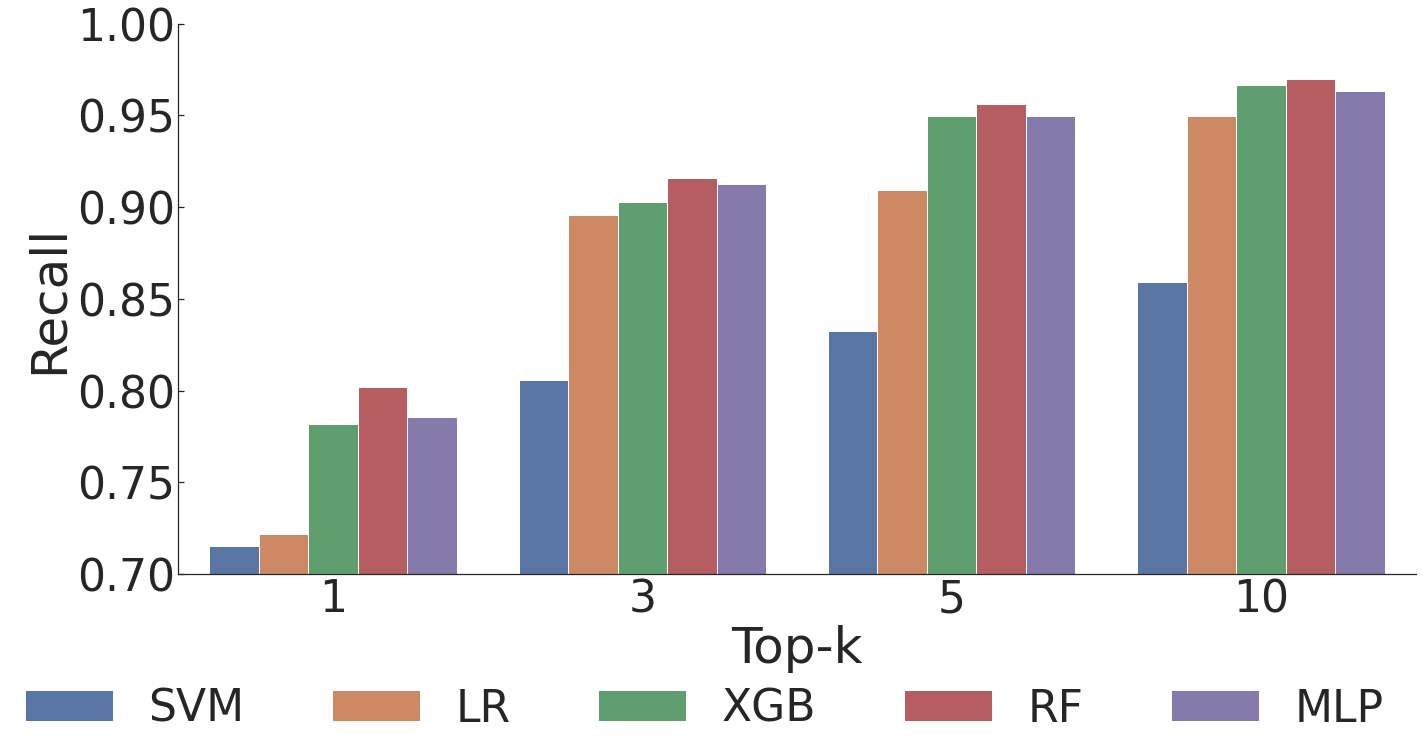

In [8]:
sns.set(rc={'figure.figsize':(9,9),"font.size":30,"axes.titlesize":30,"axes.labelsize":50},style="white", font_scale = 4)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8, "xtick.direction": "in", "ytick.direction": "in"})
plotdf = kfold_eval_res[kfold_eval_res['split'] == 'test'].copy()
plotdf = plotdf[plotdf['top_n'].isin([1,3,5,10])]
plotdf.replace(to_replace={'xgb': 'XGB', 'rforest': 'RF', 'logistic': 'LR', 'svc': 'SVM', 'mlp': 'MLP'}, inplace=True)
plotdf.rename(columns={'accuracy': 'Recall', 'split': 'Split', 'top_n': 'Top-k', 'model': 'Model'}, inplace=True)
ax = sns.catplot(data=plotdf, kind='bar', x='Top-k', y='Recall', hue='Model', height=10, aspect=2)
sns.move_legend(ax, "lower center", ncol=5, bbox_to_anchor=(.42, -0.09), title=None)
ax = ax.set(ylim=[0.7, 1.0], yticks=[0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
fig_file = fig_dir / 'topk_score_pref_btn_models.pdf'
plt.savefig(fig_file, dpi=200, bbox_inches='tight'); print(f"Saved to {fig_file}")

In [9]:
kfold_eval_res[(kfold_eval_res['split'] == 'test') & (kfold_eval_res.top_n == 5)]

,split,top_n,accuracy,model
2,test,5,0.832529,svc
2,test,5,0.909540,logistic
2,test,5,0.949770,xgb
2,test,5,0.956437,rforest
2,test,5,0.949655,mlp


# Retrain and evaluate

In [10]:
import sys; import importlib
importlib.reload(sys.modules['consent.cmp.prefbtn.pref_btn_clf'])
from consent.cmp.prefbtn.pref_btn_clf import PrefBtnClf

### Retrain & save classifier on the whole dataset.
def retrain_and_save_whole_dataset():
    print(f"Feature dimension: {feat.shape}")
    apr_df = pr_df.copy()
    PrefBtnClf.train_and_save(feat, apr_df['pref_btn'].to_list(), save=True)

    # Compute accuracy using batch (fast) computation on multiple sites.
    clf = PrefBtnClf.get_clf()
    print('Using:', clf)
    predict_dataset(clf, apr_df, feat)
    accuracies = []
    for top_n in [1,2,3]:
        accuracy = get_accuracy_top_n(apr_df, top_n=top_n)
        accuracies.append(accuracy)

    for i in [1,2,3]:
        print(f'Whole-dataset top-{i} Accuracy: {accuracies[i-1]}')
    # Compute accuracy using TestPrefBtnClf.
    test_accuracies = []
    for top_n in [1,2,3]:
        accuracy = TestPrefBtnClf.get_accuracy_top_n(PrefBtnClf.get_clf(), apr_df, feat, top_n=top_n)
        test_accuracies.append(accuracy)

    assert accuracies == test_accuracies, f'There is some mismatches: {accuracies=} {test_accuracies=}'
    print("PrefBtnClf tests passed.")

# Uncomment to retrain
retrain_and_save_whole_dataset()

Feature dimension: (71020, 17)
Saved classifier to /mnt/sda/ducbui/Dropbox/Dropbox (University of Michigan)/projects/data_sync/consent/2022-05-21/pref_btn_clf.joblib
Load classifier from /mnt/sda/ducbui/Dropbox/Dropbox (University of Michigan)/projects/data_sync/consent/2022-05-21/pref_btn_clf.joblib
Using: RandomForestClassifier(random_state=1025)
Whole-dataset top-1 Accuracy: 0.8355704697986577
Whole-dataset top-2 Accuracy: 0.9026845637583892
Whole-dataset top-3 Accuracy: 0.9261744966442953
PrefBtnClf tests passed.


In [11]:
# Parameters of the classifier.
PrefBtnClf.get_clf().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1025,
 'verbose': 0,
 'warm_start': False}

In [12]:
# Experimental
# clf = MLPClassifier(hidden_layer_sizes=(100,), random_state=1025)
# clf = LogisticRegression(C=10, random_state=1025)
# clf = xgb.XGBClassifier(n_estimators=200, max_depth=30, random_state=1025)
clf = None
kfold_results = kfold_eval(pr_df, feat, aclf=clf)
kfold_results

kfold_eval_res = kfold_results.groupby(by=['split', 'top_n']).mean().reset_index().sort_values(by=['split', 'top_n'], ascending=[False, True])
kfold_eval_res

,split,top_n,accuracy
5,train,1,0.832586
6,train,3,0.926175
7,train,5,0.963092
8,train,7,0.969429
9,train,10,0.982105
0,test,1,0.802184
1,test,3,0.916092
2,test,5,0.956437
3,test,7,0.963218
4,test,10,0.969885


In [13]:
latex_df = kfold_eval_res.copy()
latex_df['accuracy'] = kfold_eval_res['accuracy'] * 100
latex_df.rename(columns={'split': 'Dataset Split', 'top_n': 'Top-k', 'accuracy': 'Accuracy'}, inplace=True)
latex_df.replace({'train': 'Train', 'test': 'Test'}, inplace=True)
print(latex_df.to_latex(index=False, float_format='%.2f'))
        # Train &      1 &     81.02 \\
        # Train &      2 &     97.95 \\
        # Train &      3 &    100.00 \\
        #  Test &      1 &     76.25 \\
        #  Test &      2 &     96.40 \\
        #  Test &      3 &     99.41 \\

\begin{tabular}{lrr}
\toprule
Dataset Split &  Top-k &  Accuracy \\
\midrule
        Train &      1 &     83.26 \\
        Train &      3 &     92.62 \\
        Train &      5 &     96.31 \\
        Train &      7 &     96.94 \\
        Train &     10 &     98.21 \\
         Test &      1 &     80.22 \\
         Test &      3 &     91.61 \\
         Test &      5 &     95.64 \\
         Test &      7 &     96.32 \\
         Test &     10 &     96.99 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_48440/3229365740.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(latex_df.to_latex(index=False, float_format='%.2f'))


Saved to /home/ducbui/local_projects/consent/paper/sp22/figures/topk_score_pref_btn_train_test.png


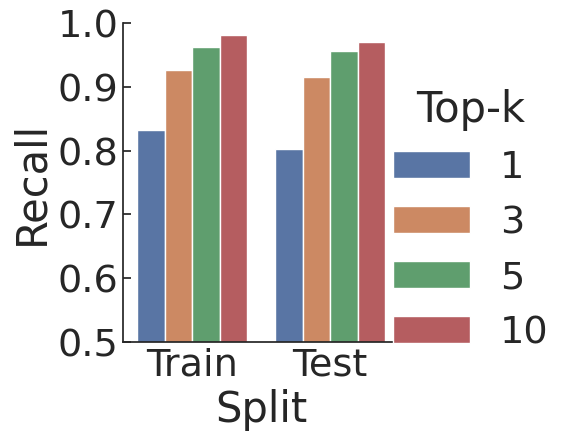

In [14]:
import matplotlib.ticker as ticker

sns.set(rc={'figure.figsize':(9,9),"font.size":30,"axes.titlesize":30,"axes.labelsize":30},style="white", font_scale = 2.5)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8, "xtick.direction": "in", "ytick.direction": "in"})
plotdf = kfold_eval_res.copy()
plotdf = plotdf[plotdf['top_n'].isin([1,3,5,10])]
plotdf.replace(to_replace={'train': 'Train', 'test': 'Test'}, inplace=True)
plotdf.rename(columns={'accuracy': 'Recall', 'split': 'Split', 'top_n': 'Top-k'}, inplace=True)
ax = sns.catplot(data=plotdf, kind='bar', x='Split', y='Recall', hue='Top-k')
ax.set(ylim=(0.5, 1.0), yticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

fig_file = fig_dir / 'topk_score_pref_btn_train_test.png'
plt.savefig(fig_file, dpi=200, bbox_inches='tight'); print(f"Saved to {fig_file}")

In [15]:
tmpdf = plotdf.pivot(index='Top-k', columns='Split')
tmpdf.columns = [a[1] for a in tmpdf.columns.to_flat_index()]
tmpdf = tmpdf[['Train', 'Test']].reset_index()
print(tmpdf.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{rrr}
\toprule
 Top-k &  Train &  Test \\
\midrule
     1 &   0.83 &  0.80 \\
     3 &   0.93 &  0.92 \\
     5 &   0.96 &  0.96 \\
    10 &   0.98 &  0.97 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_48440/2408437963.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tmpdf.to_latex(index=False, float_format="%.2f"))


# Ablation study

In [16]:
# Ablation study on the number of dimensions.
# import sys; import importlib
# importlib.reload(sys.modules['consent.cmp.prefbtn.pref_btn_clf'])
# from consent.cmp.prefbtn.pref_btn_clf import PrefBtnClf

group_names = [f'G{i + 1}' for i in range(len(feat_group_dims))]

dim_res_dfs = []
for i, group_name in enumerate(group_names):
    group_dim = acc_group_dims[i]
    afeat = feat[:,:group_dim]
    dim_res = get_kfold_eval_res(pr_df, afeat)
    dim_res['dim'] = [group_dim] * len(dim_res)
    dim_res_dfs.append(dim_res)

dim_res = pd.concat(dim_res_dfs)
dim_res.sort_values(['split', 'top_n', 'dim'])

,split,top_n,accuracy,dim
0,test,1,0.765172,12
0,test,1,0.782299,15
0,test,1,0.802184,17
1,test,3,0.889195,12
1,test,3,0.902644,15
1,test,3,0.916092,17
2,test,5,0.922874,12
2,test,5,0.936322,15
2,test,5,0.956437,17
3,test,7,0.933103,12


In [36]:
path = Path.home() / "tmp/dim_res.csv"
dim_res = pd.read_csv(path, header=0, index_col=None)

Saved to /home/ducbui/local_projects/consent/paper/sp22/figures/ablation_topk_score_pref_btn.png


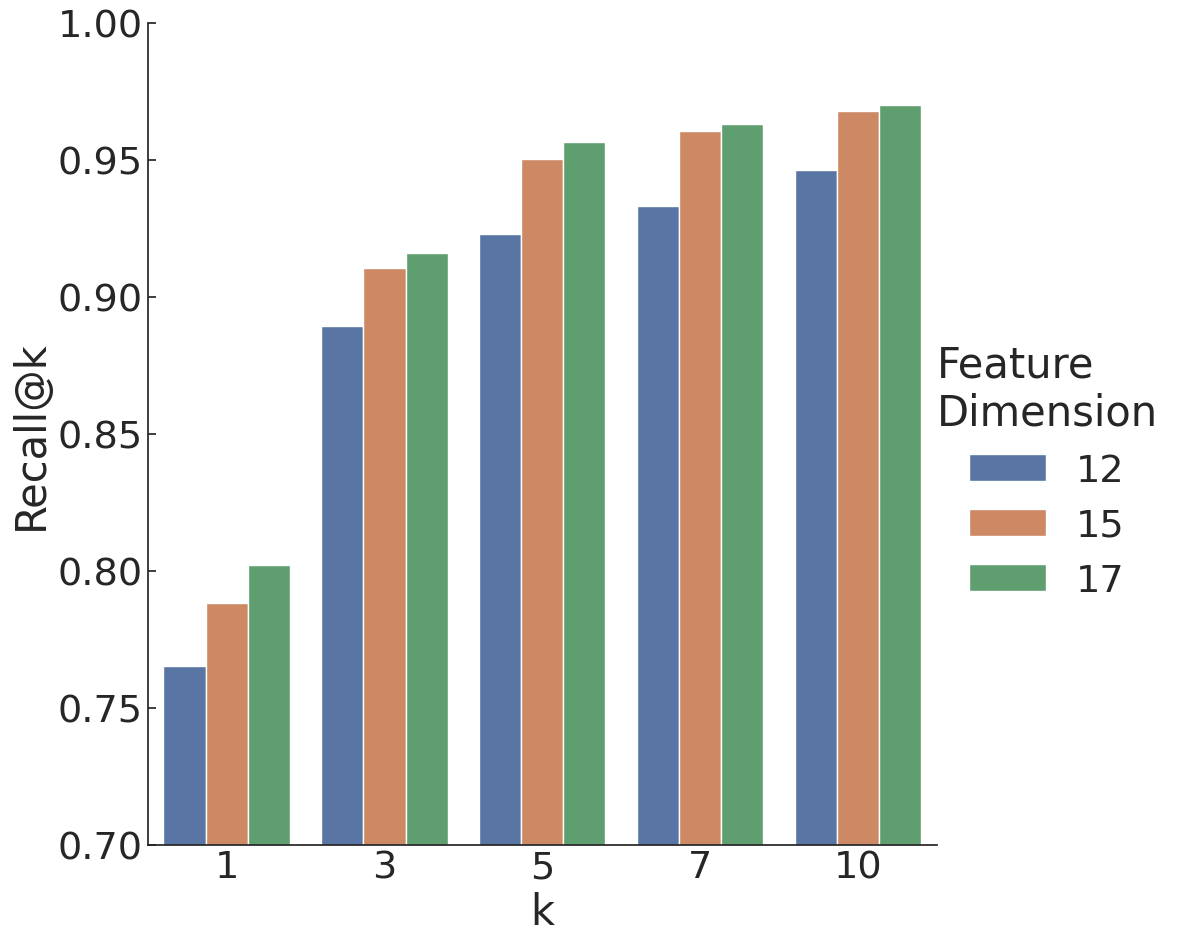

In [38]:
# for split in ['test']:
    # print('Split', split)
split = 'test'
adim_res = dim_res[dim_res.split==split]
assert len(adim_res) > 0

# sns.set(rc={'figure.figsize':(15,15),"font.size":30,"axes.titlesize":30,"axes.labelsize":30},style="white", font_scale = 2.5)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8, "xtick.direction": "in", "ytick.direction": "in"})

plotdf = adim_res.copy()
# plotdf.replace(to_replace={'train': 'Train', 'test': 'Test'}, inplace=True)
plotdf.rename(columns={'accuracy': 'Recall@k', 'split': 'Split', 'top_n': 'k', 'dim': 'Feature\nDimension'}, inplace=True)
# ax = sns.catplot(data=plotdf, kind='bar', x='Split', y='Accuracy', hue='Top-k')
ax = sns.catplot(data=plotdf, kind='bar', x='k', y='Recall@k', hue='Feature\nDimension', height=10)
ax.set(ylim=(.7, 1.0))
# ax.set_size_inches(18.5, 10.5)


fig_file = fig_dir / 'ablation_topk_score_pref_btn.png'
plt.savefig(fig_file, dpi=200, bbox_inches='tight'); print(f"Saved to {fig_file}")

# for dim in acc_group_dims[:]:
#     print('Dim', dim)
#     adim_res = dim_res[dim_res.dim==dim]
#     assert len(adim_res) > 0
#     ax = sns.catplot(data=adim_res, kind='bar', x='split', y='accuracy', hue='top_n')

# Preference button label distribution.

Saved to /home/ducbui/local_projects/consent/paper/sp22/figures/preference_button_label_dist.pdf


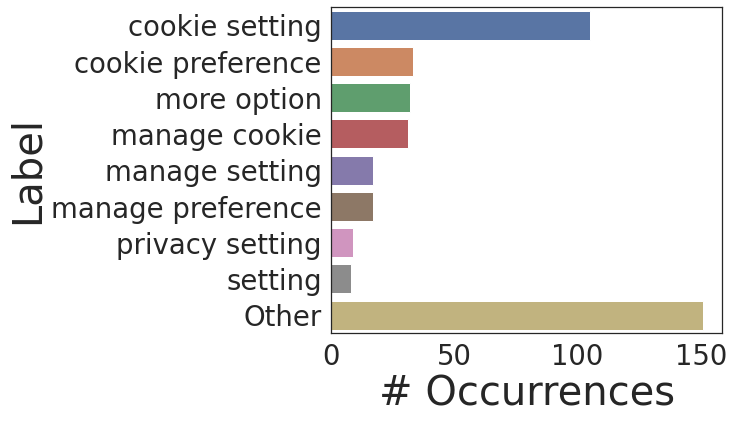

In [81]:
column = 'inner_text'
prefs = pr_df[~pr_df[column].isna() & pr_df.pref_btn ].reset_index(drop=True)
pref_texts = [get_spaced_lemma(text.lower()) for text in prefs.inner_text if len(text) > 0]
pref_text_vc = pd.DataFrame(Counter(pref_texts).most_common(), columns=['label', 'freq'])
thrhold= 7
more_common = pref_text_vc[pref_text_vc.freq > thrhold]
less_common = pref_text_vc[pref_text_vc.freq < thrhold]
other_freq = less_common.freq.sum()
more_common = pd.concat([more_common, pd.DataFrame({'label': ['Other'], 'freq': [other_freq]})])
more_common.replace({'do not sell my personal information': 'DNSMPI'}, inplace=True)
sns.set(rc={'figure.figsize':(7,6),"font.size":40,"axes.titlesize":30,"axes.labelsize":40},style="white", font_scale = 2.5)
ax = sns.barplot(y=more_common.label, x=more_common.freq)
ax.set(xlabel='# Occurrences', ylabel='Label')
# ticks = plt.xticks(rotation=45, ha='right')
fig_file = fig_dir / 'preference_button_label_dist.pdf'
plt.savefig(fig_file, dpi=200, bbox_inches='tight'); print(f'Saved to {fig_file}')

In [82]:
pref_text_vc.label.map(num_tokens).value_counts().sort_index()

1    14
2    41
3    33
4    12
5     1
6     2
9     1
Name: label, dtype: int64

In [83]:
# Extract ngrams
from consent.cmp.prefbtn.pref_btn_featurizer import analyze_grams, tokenize
btns = pref_df[pref_df.pref_btn].copy()
tokenize(btns)
analyze_grams(btns)

unigrams
 ['ad', 'adchoice', 'adjust', 'base', 'change', 'choice', 'choose', 'click', 'configuration', 'configure', 'consent', 'cookie', 'customise', 'customize', 'datum', 'detail', 'gdpr', 'individual', 'info', 'information', 'interest', 'learn', 'let', 'manage', 'manager', 'manually', 'modal', 'open', 'opt', 'option', 'parameter', 'personal', 'personalize', 'policy', 'preference', 'privacy', 'purpose', 'review', 'secondary', 'select', 'sell', 'set', 'setting', 'specific', 'storage', 'tool', 'tracker', 'update', 'use', 'view', 'window']
bigrams
 ['ad choice', 'ad consent', 'adjust consent', 'adjust cookie', 'base ad', 'change consent', 'change cookie', 'change preference', 'change privacy', 'change setting', 'choose specific', 'configure consent', 'consent choice', 'consent detail', 'consent manager', 'consent modal', 'consent option', 'consent preference', 'consent tool', 'cookie ad', 'cookie choice', 'cookie consent', 'cookie learn', 'cookie policy', 'cookie preference', 'cookie sel

In [84]:
anomalies = btns[btns.inner_text.str.contains('window', case=False)]
anomalies = btns[btns.aria_label.str.contains('secondary', case=False)]
anomalies = btns[btns.inner_text.str.contains('let', case=False)]
anomalies
# anomalies[anomalies.pref_btn]

,id,class,tag_name,text_content,inner_text,aria_label,title,href,onclick,pref_btn,site,inner_text_tokens,aria_label_tokens,title_tokens,id_tokens,class_tokens
74,let_me_choose,second_button right,BUTTON,Let me choose,Let me choose,,,,,True,royalmail.com,"[let, choose, let choose]",[],[],"[let, I, choose, let I, I choose]","[second, button, right, second button, button ..."
